# Choose your own adventure

A simple text-based game in the style of 80s adventure games in which you play a hungry corgi.

## Setup

In [1]:
import json
from typing import Optional, Tuple

from burr.core import action, Application, ApplicationBuilder, State, default, when
from openai import OpenAI

In [ ]:
# set your OpenAI API key to run the rest of the notebook
import os
os.environ["OPENAI_API_KEY"] = ...

In [11]:
RESTRICTIONS = """You're a small corgi with short legs. You can't jump high,
you can't run fast, you can't perform feats of athleticism in general
to achieve any of your goals. You can't open doors, you can't use tools,
you can't communicate with humans, you can't use your paws to manipulate
objects, you can't use your mouth to communicate with humans"""

## Define actions

In [12]:

@action(reads=["challenges"], writes=["current_challenge"])
def start(state: State) -> State:
    """Load the first challenge as the current challenge"""
    current_challenge = state["challenges"][0]
    return state.update(current_challenge=current_challenge)


@action(reads=["current_challenge"], writes=["attempts"])
def prompt_for_challenge(state: State) -> State:
    """Request user input to solve the current challenge"""
    current_challenge = state["current_challenge"]
    user_response = input(f'{current_challenge}. What do you do?\n $ ')
    return state.append(attempts=user_response)


@action(
    reads=["attempts", "current_challenge"],
    writes=["challenge_solved", "what_happened"],
)
def evaluate_attempt(state: State) -> State:
    response = OpenAI().chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {
                "role": "system",
                "content": f"""You are evaluating responses for
             whether they constitute solutions to the provided challenge in a text
             based game, whose protagonist is a dog subject to the following limitations:
             {RESTRICTIONS}. You respond ONLY with a json object containing two fields: "solved", which is a
             boolean indicating whether the challenge was solved by the attempt, and "what_happened",
             which is a string containing a brief narrative, written in the second person and addressed
             to the player, of what happened during the protagonist's attempt""",
            },
            {
                "role": "user",
                "content": f"The current challenge is: {state['current_challenge']} "
                f"and the player's attempt is: {state['attempts'][-1]}",
            },
        ],
    )
    content = response.choices[0].message.content
    try:
        json_result = json.loads(content)
    except json.JSONDecodeError:
        print("bad json: ", content)
        json_result = {
            "solved": False,
            "what_happened": "Not sure, really. I'm a dog. I can't read json. I can't read at all.",
        }

    return state.update(
        challenge_solved=json_result["solved"],
        what_happened=json_result["what_happened"],
    )


@action(
    reads=["challenge_solved", "current_challenge", "what_happened"],
    writes=["current_challenge", "did_win"],
)
def maybe_progress(state: State) -> State:
    print("What happened:", state["what_happened"])
    if state["challenge_solved"]:
        if state["current_challenge"] == challenges[-1]:
            result = {"did_win": True}
        else:
            result = {
                "current_challenge": challenges[challenges.index(state["current_challenge"]) + 1]
            }
    else:
        result = {"current_challenge": state["current_challenge"]}
    return state.update(**result)


@action(reads=["challenges"], writes=[])
def win(state: State) -> State:
    # get summary of actions taken from openai
    print("you won")
    return state


In [13]:
challenges = [
    "There is a dish of dog food on the floor. You want to eat it",
    "There is a dish of dog food on a table. You want to eat it",
    "There is a dish of dog food in a locked car. You want to eat it",
]

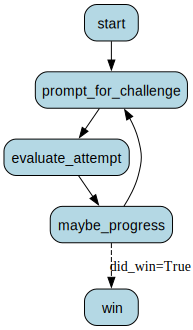

In [14]:
def build_application(
    app_id: Optional[str] = None,
    storage_dir: Optional[str] = "~/.burr",
) -> Application:
    return (
        ApplicationBuilder()
        .with_state(did_win=False, challenges=challenges)
        .with_actions(
            start=start,
            prompt_for_challenge=prompt_for_challenge,
            evaluate_attempt=evaluate_attempt,
            maybe_progress=maybe_progress,
            win=win,
        )
        .with_transitions(
            ("start", "prompt_for_challenge", default),
            ("prompt_for_challenge", "evaluate_attempt", default),
            ("evaluate_attempt", "maybe_progress", default),
            ("maybe_progress", "win", when(did_win=True)),
            ("maybe_progress", "prompt_for_challenge", default),
        )
        .with_entrypoint("start")
        .with_tracker(project="demo_corgi_adventure", params={"storage_dir": storage_dir})
        .with_identifiers(app_id=app_id)
        .build()
    )

app = build_application()
app.visualize(output_file_path="digraph", include_conditions=True, view=False, format="png")

In [15]:
action, state, result = app.run(halt_after=["win"])

What happened: You opened your mouth and attempted to eat the food, but without the ability to manipulate the dish, you couldn’t reach the food. It remained untouched on the floor, taunting you with its delicious aroma.
What happened: You tugged at the dish with your mouth, but your short legs can't provide enough strength to pull it any closer. The dish remains out of reach, and your belly rumbles in disappointment as you realize you can't manipulate it like you hoped.
What happened: You approach the dish of dog food with eager anticipation, but as you try to lean over and take a bite, your short legs make it difficult to reach the food comfortably. You can't quite get your mouth to the dish, and after a few attempts, you realize you'll need a different plan to enjoy your meal.
What happened: You try to bite the side of the dish to tip it over, but your short legs and limited strength make it impossible. The dish remains firmly on the floor, and the tantalizing smell of the dog food w

KeyboardInterrupt: Interrupted by user